# Setup

## Imports

In [2]:
import itertools
import os.path
import cupy as cp

from tqdm import tqdm_notebook

vai Modules

In [3]:
from vaiutils import plot_images, path_consts, randpick

Keras Modules

In [4]:
import keras.backend as K

## Define Useful Variables and Functions

In [5]:
for k, v in path_consts('COCO'):
    exec(k+'=v')

Custom Modules

In [6]:
from colorizer import rgb_to_lab, lab_to_rgb

In [64]:
pixel = K.placeholder((None, None, 3))
rgb2lab = K.Function([pixel], [rgb_to_lab(pixel)])
lab2rgb = K.Function([pixel], [lab_to_rgb(pixel)])

In [14]:
ab_range = (-130, 131)
ab_step = 10

## Checks

In [ ]:
assert not os.path.exists(os.path.join(DIR_CHECKPOINTS, 'ab_bins.npy')), 'No need to proceed!'

# Extract Gamut Bins

In [22]:
rgb_values = np.stack(itertools.product(*[np.arange(256)]*3))

In [32]:
lab_values = rgb2lab([np.expand_dims(rgb_values.astype(float)/255, 0)])[0][0]

In [44]:
lab_values = cp.array(lab_values)

## Find all values within gamut

In [37]:
ab_bins = np.stack(itertools.product(*[np.arange(ab_range[0], ab_range[1], ab_step)]*2))

In [41]:
ab_bins = cp.array(ab_bins)

In [42]:
def in_gamut(ab):
    ab_low, ab_high = ab, ab + 10
    return cp.any(cp.all(lab_values[:, 1:] > ab_low, -1) * cp.all(lab_values[:, 1:] < ab_high, -1))

In [45]:
ab_bins = cp.stack([ab for ab in tqdm_notebook(ab_bins) if in_gamut(ab)])

HBox(children=(IntProgress(value=0, max=729), HTML(value='')))

In [46]:
ab_bins = cp.asnumpy(ab_bins)
lab_values = cp.asnumpy(lab_values)

In [47]:
np.save(os.path.join(DIR_CHECKPOINTS, 'ab_bins'), ab_bins)

## Show the gamut

In [50]:
lab_gamut = np.ones((ab_bins.shape[0], 3)) * 50
lab_gamut[:, 1:] = ab_bins
    
color_gamut = lab2rgb([np.expand_dims(lab_gamut, 0)])[0][0]

In [52]:
def plot_gamut(alpha=None, save=False):
    if alpha is not None:
        colors = np.append(color_gamut, np.expand_dims(alpha, -1), -1)
    else:
        colors = color_gamut
        
    plt.scatter(ab_bins[:, 1], ab_bins[:, 0], 700, colors,'s')
    for i in range(len(ab_bins)):
        plt.annotate(str(i), (ab_bins[i, 1] - 3, ab_bins[i, 0] + 1), size=10, color='w')
    plt.xlabel('b')
    plt.ylabel('a')
    plt.xlim(-110, 110)
    plt.ylim(-110, 110)
    plt.xticks(np.arange(-110, 110, 55))
    plt.yticks(np.arange(-110, 110, 55))
    plt.gca().invert_yaxis()
    plt.gcf().set_size_inches((10, 10))
    plt.grid('off')
    plt.title('ab Gamut - sRGB')
    if save:
        plt.savefig(os.path.join(DIR_OUTPUT, 'ab_gamut.jpg'), dpi=400)
    plt.show()

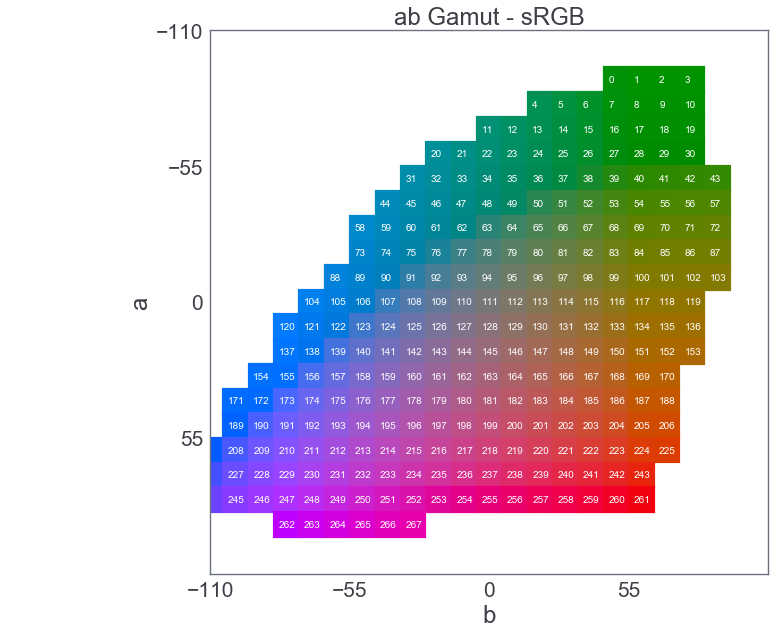

In [53]:
plot_gamut(save=True)

# Experiments

In [54]:
bins = cp.array(ab_bins)
Q = len(ab_bins)

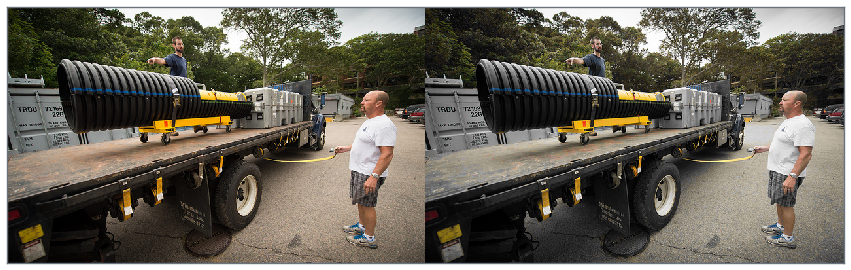

In [127]:
img = imread(randpick(os.path.join(DIR_DATA, 'val2017', '*.jpg'))).copy()
img_lab = rgb2lab([img/255])[0]

img_ab = np.take((img_lab / 10).astype(int) * 10, [1, 2], -1)

img_lab[:, :, 1:] = img_ab
plot_images([img, lab2rgb([img_lab])[0]*255])